In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [13]:
data='https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
table=pd.read_csv(data)
table = table[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','city mpg','highway MPG','MSRP']]
table

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,city mpg,highway MPG,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,19,26,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,19,28,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,20,28,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,18,28,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,18,28,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,50920


In [14]:
table.columns = table.columns.str.replace(' ', '_').str.lower()
table=table.fillna(0)
table=table.rename(columns={'msrp':'price'})
table['above_average'] = (table.price > np.mean(table.price)).astype(int)
table

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,city_mpg,highway_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,19,26,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,19,28,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,20,28,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,18,28,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,18,28,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,16,23,50920,1


In [18]:
df_train_full, df_test = train_test_split(table, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
y_train = df_train.above_average.values
y_val = df_val.above_average.values
del df_train['price']
del df_val['price']
del df_train['above_average']
del df_val['above_average']
categorical=['make','model','transmission_type','vehicle_style']
numerical=['year','engine_hp','engine_cylinders','city_mpg','highway_mpg',]

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
for i in numerical:
    auc = roc_auc_score(y_train, df_train[i])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -1*df_train[i])
    print(i,auc)
  #engine hp has highest


year 0.687551492804683
engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
city_mpg 0.6734244643245233
highway_mpg 0.6330587871772013


In [21]:
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [22]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model.fit(X_train, y_train)
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [26]:
round(roc_auc_score(y_val, y_pred),4)
# 0.979 is score

0.9797

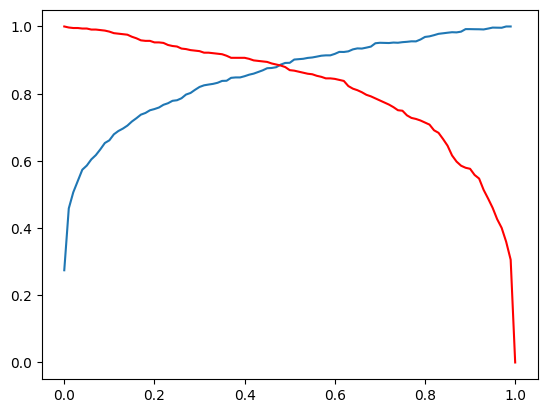

In [32]:
def confusion(y_val, y_pred):
    score = []
    threshold = np.linspace(0, 1, 101)
    for t in threshold:
        actual_pos = (y_val == 1)
        actual_neg = (y_val == 0)
        predict_pos = (y_pred >= t)
        predict_neg = (y_pred < t)
        tp = (predict_pos & actual_pos).sum()
        tn = (predict_neg & actual_neg).sum()
        fp = (predict_pos & actual_neg).sum()
        fn = (predict_neg & actual_pos).sum()
        score.append((t, tp, fp, fn, tn))
    return pd.DataFrame(score, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
cm=confusion(y_val, y_pred)
cm['precision'] = cm.tp / (cm.tp + cm.fp)
cm['recall'] = cm.tp / (cm.tp + cm.fn)
plt.plot(cm.threshold, cm.precision, label='precision')
plt.plot(cm.threshold, cm.recall, label='recall',color='red')
plt.show()
#cross at 0.5~0.48


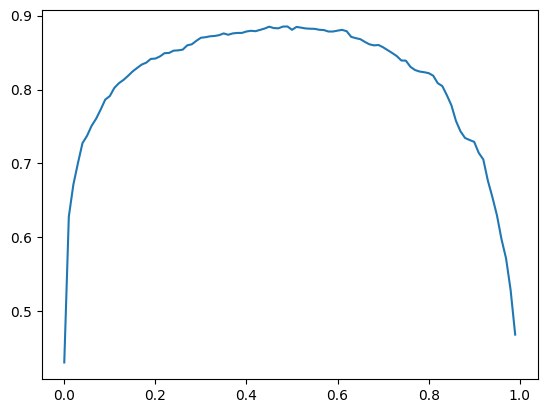

In [35]:
cm['f1'] = 2 * cm.precision * cm.recall / (cm.precision + cm.recall)
plt.plot(cm.threshold, cm.f1)
#max f1 at 0.52

In [38]:
def train(df_train, y_train, C=1):
    dict = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dict)
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)
    return dv, model
def predict(df, dv, model):
    dict = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dict)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5, shuffle=True, random_state=1)
score = []
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    y_train = df_train.above_average
    y_val = df_val.above_average
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    score.append(auc)

print((np.mean(score), np.std(score)))
#close to 0.003

(0.9793078945520477, 0.002060199182252492)


In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for i in [0.01, 0.1, 1, 10]:
    score = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        y_train = df_train.above_average
        y_val = df_val.above_average
        dv, model = train(df_train, y_train, C=i)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        score.append(auc)
    print(i, np.mean(score), np.std(score))
#C=10 is highest

0.01 0.9516232719893825 0.002533538664405695
0.1 0.9717986426078367 0.0015904615088676397
1 0.9793078945520477 0.002060199182252492
10 0.9813388673239005 0.0032641124348568875
